# PINN Style Investigations

## Optmises the equation coeffs only using target and reference data. No NN. 

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append('../src')
from deepymod_torch.library_function import mech_library_least_squares
from deepymod_torch.DeepMod import DeepMoD_least_squares
from deepymod_torch.VE_params import coeffs_from_model_params, model_params_from_coeffs

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
Input_Type = 'Strain'
Input_Function = lambda time_data: torch.sin(time_data)/time_data

In [3]:
data = np.loadtxt('../data/StressStrain/Strain Sinc E[1, 10, 1] V[20, 20].csv', delimiter=',')
time_Array, strain_array, Stress_Array = data[:,0:1], data[:,1:2], data[:,2:]

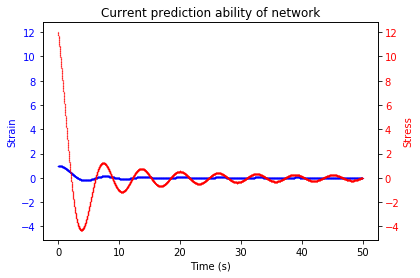

In [4]:
fig, ax1 = plt.subplots()
plt.title('Current prediction ability of network')
ax1.set_xlabel('Time (s)')
colour = 'blue'
ax1.set_ylabel('Strain', color=colour)
ax1.plot(time_Array, strain_array, color=colour, linestyle='None', marker='.', markersize=0.5)
ax1.tick_params(axis='y', labelcolor=colour)
ax2 = ax1.twinx()
colour = 'red'
ax2.set_ylabel('Stress', color=colour)
ax2.plot(time_Array, Stress_Array, color=colour, linestyle='None', marker='.', markersize=0.5)
ax2.tick_params(axis='y', labelcolor=colour)
ax1.set_ylim(ax2.get_ylim())
plt.show()

In [5]:
noise_level = 0.05
#noisy_stress_array = Stress_Array + noise_level * np.std(Stress_Array) * np.random.standard_normal(Stress_Array.shape)
noisy_stress_array = Stress_Array

In [6]:
number_of_samples = 1000

reordered_row_indices = np.random.permutation(time_Array.size)
#reduced_time_array = time_Array[reordered_row_indices, :][:number_of_samples]
#reduced_stress_array = noisy_stress_array[reordered_row_indices, :][:number_of_samples]
reduced_time_array = time_Array
reduced_stress_array = noisy_stress_array

In [7]:
time_Tensor = torch.tensor(reduced_time_array, dtype=torch.float32, requires_grad=True)
Stress_Tensor = torch.tensor(reduced_stress_array, dtype=torch.float32)

no matter that lambda is unchanged, the function changes this itself to zero. This is already part of the default flow so i kept it in.

In [8]:
optim_config = {'lambda': 10**-5, 'max_iterations': 50001}

In [9]:
lib_config = {'type': mech_library_least_squares, 'diff_order': 2, 'coeff_sign': 'positive', 'input_type': Input_Type, 'input_expr': Input_Function}

prediction of what we are aiming for

In [10]:
not_floats = coeffs_from_model_params([1, 10, 1], [20, 20])
float_coeffs = [float(x) for x in not_floats]
float_coeffs

[0.045454545454545456,
 1.8181818181818181,
 0.09545454545454546,
 1.1818181818181819,
 1.8181818181818181]

In [11]:
sparse_coeff_vector, sparsity_mask = DeepMoD_least_squares(time_Tensor, Stress_Tensor, lib_config, optim_config)

Epoch | PI loss 
0 7.4E-01
tensor([[1.5245],
        [0.3158],
        [0.4494],
        [0.8504],
        [0.3599]], requires_grad=True)
Time elapsed: 0.0 minutes 0.026807546615600586 seconds
Epoch | PI loss 
5000 3.4E-04
tensor([[0.5520],
        [2.1121],
        [0.0630],
        [0.1236],
        [0.1804]], requires_grad=True)
Time elapsed: 0.0 minutes 8.900922060012817 seconds
Epoch | PI loss 
10000 1.6E-05
tensor([[0.0491],
        [1.8632],
        [0.0352],
        [0.1499],
        [0.1563]], requires_grad=True)
Time elapsed: 0.0 minutes 17.118973970413208 seconds
Epoch | PI loss 
15000 2.5E-06
tensor([[0.0555],
        [0.6222],
        [0.0384],
        [0.1061],
        [0.0520]], requires_grad=True)
Time elapsed: 0.0 minutes 25.67532730102539 seconds
Epoch | PI loss 
20000 8.6E-07
tensor([[0.0585],
        [0.0319],
        [0.0400],
        [0.0853],
        [0.0024]], requires_grad=True)
Time elapsed: 0.0 minutes 34.20154929161072 seconds
Epoch | PI loss 
25000 8.4E-07


In [12]:
sparse_coeff_vector[0][0, 0]

tensor(0.0587, grad_fn=<SelectBackward>)

In [13]:
Model_Params = model_params_from_coeffs(sparse_coeff_vector[0].detach())
Model_Params

([(18.9832933999502,
   31.7187234695643,
   1.66897748323285,
   0.249768614380987,
   28.4431244025140)],
 [E_0, E_1, E_2, eta_1, eta_2])

In [14]:
import sympy as sym

sys.path.append('../')
import data.Generation.VE_DataGen_Functions as vedg

In [15]:
Input_Type = 'Strain'
E = list(Model_Params[0][0][:3])
eta = list(Model_Params[0][0][3:])
t = sym.symbols('t', real=True)
Input_Function = sym.sinc(t)
Input_Description = 'Sinc'
Int_Type = 'Numerical'

In [16]:
Tuple_of_Expressions = vedg.Stress_Strain_Master_Int(Input_Type, E, eta, Input_Function, Int_Type, t)
Tuple_of_Expressions

(18.9832933999502 + 31.7187234695643*exp(-126.99243076707*t) + 1.66897748323285*exp(-0.0586777127440095*t),
 <function data.Generation.VE_DataGen_Functions.Stress_Strain_Master_Int.<locals>.<lambda>(t)>)

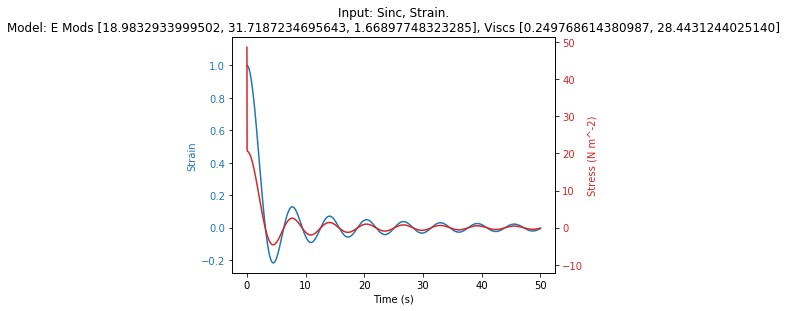

In [17]:
time = np.linspace(0.001, 50, 5000)

title = ('Input: ' + Input_Description + ', ' + Input_Type + 
         '.\nModel: E Mods ' + str(E) + ', Viscs ' + str(eta))

result_strain_array, result_stress_array = vedg.Eval_Graph_Strain_Stress(title, time, Input_Function, Tuple_of_Expressions, Input_Type, Int_Type, t)

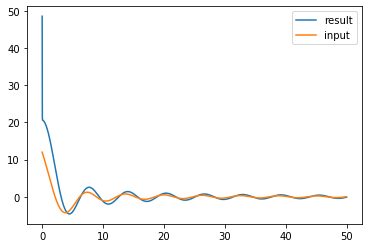

In [19]:
plt.plot(time, result_stress_array, label='result')
plt.plot(time, Stress_Array, label='input')
plt.legend()

In [20]:
time_deriv_list, theta = mech_library_least_squares(time_Tensor, Stress_Tensor, lib_config)

In [21]:
b = time_deriv_list[0].detach().numpy()
b

array([[-0.00036621],
       [-0.00366974],
       [-0.00699997],
       ...,
       [ 0.01931092],
       [ 0.01935857],
       [ 0.01940427]], dtype=float32)

In [22]:
a = theta.detach().numpy()
a

array([[-9.9999988e-01,  1.2500000e-01,  1.1994949e+01, -5.0589991e+00,
        -7.4668795e-01],
       [-9.9997985e-01,  3.3398438e-01,  1.1944350e+01, -5.0664673e+00,
        -1.1178284e+00],
       [-9.9992651e-01,  3.3349609e-01,  1.1893602e+01, -5.0813599e+00,
        -1.4889984e+00],
       ...,
       [ 5.6347451e-03, -4.8619998e-03,  1.5683578e-02,  2.1596420e-01,
        -3.1041145e-02],
       [ 5.4413541e-03, -4.6668560e-03,  1.7842129e-02,  2.1564299e-01,
        -2.4350166e-02],
       [ 5.2474970e-03, -4.4713253e-03,  1.9997360e-02,  2.1547709e-01,
        -1.6585920e-02]], dtype=float32)

In [23]:
x = sparse_coeff_vector[0].detach().numpy()
x

array([[0.05865061],
       [0.00787085],
       [0.04008032],
       [0.08446718],
       [0.00041462]], dtype=float32)

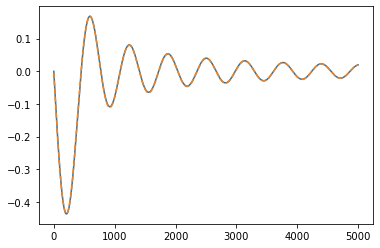

In [24]:
plt.plot(b)
plt.plot(a @ x, '--')

In [26]:
np.savetxt('../data/StressStrain'+'/'+'DM_Style_50'+'.csv', b, delimiter=',')